In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn
import yaml
import sys
import glob
import os
%matplotlib inline

sns.set(font_scale=1.5, style='white')

In [2]:
def sum_cpu(node_res):
    """Return sum of CPU resources allocated to all nodes"""
    cpu = sum([v['cpu'] for v in node_res])
    return cpu

def read_placement(placement, df_data, flow_dr=250):
    """Read placement dict and write it to df_data. Then return."""
    df_data['num_flows'].append(placement['input']['num_flows'])
    df_data['num_sources'].append(placement['input']['num_sources'])
    df_data['source_dr'].append(placement['input']['num_flows'] * flow_dr)
    df_data['num_instances'].append(placement['metrics']['num_instances'])
    df_data['max_e2e_delay'].append(placement['metrics']['max_endToEnd_delay'])
    df_data['total_delay'].append(placement['metrics']['total_delay'])
    df_data['runtime'].append(placement['metrics']['runtime'])
    df_data['total_cpu'].append(sum_cpu(placement['placement']['alloc_node_res']))
    return df_data

def read_results(results):
    """Read result files matching the pattern and return df containing their metrics"""
    data = {'num_sources' : [], 'num_flows': [], 'source_dr': [], 'num_instances': [], 
            'max_e2e_delay': [], 'total_delay': [], 'runtime': [], 'total_cpu': []}

    # iterate through result files
    for res in glob.glob(results):
        # open and save metrics of interest
        with open(res, 'r') as f:
            placement = yaml.load(f)
            data = read_placement(placement, data)

    return pd.DataFrame(data).sort_values(by=['num_flows'])

In [3]:
# read results
dataset = 'web_data'
sources = 'three_source_dr250'
results = f'placement_data/{dataset}/{sources}/'

df_true = read_results(results + 'true/*.yaml')
df_fixed = read_results(results + 'fixed/*.yaml')
df_linear = read_results(results + 'linear/*.yaml')
df_boost = read_results(results + 'boosting/*.yaml')
df_svr = read_results(results + 'svr/*.yaml')
df_ml = read_results(results + 'ml/*.yaml')

df_linear

,num_sources,num_flows,source_dr,num_instances,max_e2e_delay,total_delay,runtime,total_cpu
0,3,3,750,9,60,60,0.265596,0.193674
2,3,6,1500,9,60,60,0.531128,0.738690
3,3,9,2250,9,60,60,1.305755,1.297319
4,3,12,3000,9,60,60,2.744371,1.855947
5,3,15,3750,9,60,60,2.175641,2.414575
6,3,18,4500,9,60,60,1.671481,2.973203
7,3,21,5250,11,64,84,2.366502,3.348957
8,3,24,6000,11,64,84,2.171408,3.907585
9,3,27,6750,11,66,87,2.488693,4.466213
1,3,30,7500,10,66,78,4.109910,5.116278


In [15]:
def plot(x_col, x_label, y_col, y_label):
    fig, ax = plt.subplots()
    
#     plt.plot(df_true[x_col], df_true[y_col], label='True', color='black', marker='o')
    plt.plot(df_fixed[x_col], df_fixed[y_col], label='Fixed', color='green', marker='+')
    plt.plot(df_linear[x_col], df_linear[y_col], label='Linear', color='blue', marker='x')
#     plt.plot(df_boost[x_col], df_boost[y_col], label='Boosting', color='red', marker='^')
#     plt.plot(df_svr[x_col], df_svr[y_col], label='SVR', color='orange', marker='v')
    plt.plot(df_ml[x_col], df_ml[y_col], label='SVR+Boosting', color='red', marker='s')
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    
    fig.savefig(f'plots/{dataset}_{y_col}.pdf')

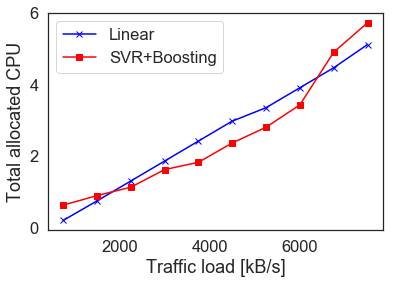

In [16]:
plot('source_dr', 'Traffic load [kB/s]', 'total_cpu', 'Total allocated CPU')

In [28]:
# max difference between different models
max(df_linear['total_delay'] / df_ml['total_delay'])
# df_linear['total_delay'] / df_ml['total_delay']
# df_linear['total_cpu'] / df_ml['total_cpu']
# max(df_ml['total_cpu'] / df_linear['total_cpu'])

1.2253521126760563

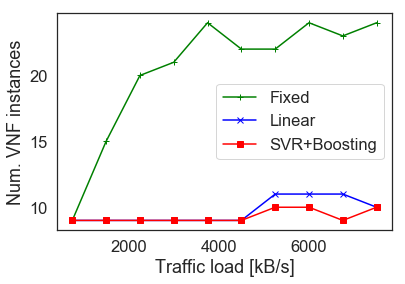

In [6]:
plot('source_dr', 'Traffic load [kB/s]', 'num_instances', 'Num. VNF instances')

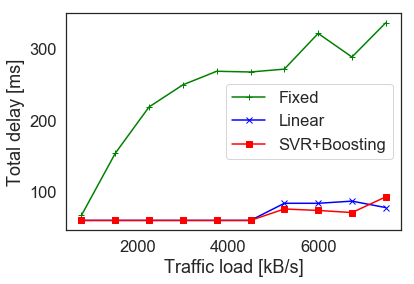

In [7]:
plot('source_dr', 'Traffic load [kB/s]', 'total_delay', 'Total delay [ms]')

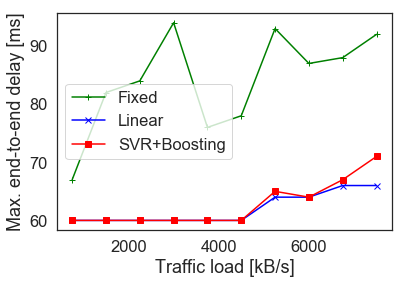

In [8]:
plot('source_dr', 'Traffic load [kB/s]', 'max_e2e_delay', 'Max. end-to-end delay [ms]')